# Portfolio Risk Management Analysis
## Q3 in HW4 and HW5

In [44]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from arch import arch_model


In [45]:
# Load the data
df = pd.read_csv('NAV.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df = df.set_index('Date')
df['returns'] = df['NAV'].pct_change() * 100
df = df.dropna()

print(f"Data loaded: {len(df)} observations")
print(f"Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
df.head()


Data loaded: 4025 observations
Period: 2001-01-02 to 2016-12-30


,NAV,returns
Date,,
2001-01-02,97.20,-2.800000
2001-01-03,102.25,5.195473
2001-01-04,101.16,-1.066015
2001-01-05,98.51,-2.619612
2001-01-08,98.34,-0.172571


## Part (a): Monthly Realized Volatility
Compute the monthly realized volatility for the portfolio. Plot the realized volatility series, and comment on its properties.

In [46]:
# Resample returns to monthly frequency and compute realized volatility
# Realized volatility = sqrt(sum of squared daily returns within each month)
monthly_realized_vol = df['returns'].resample('ME').apply(
    lambda x: np.sqrt((x**2).sum())
)

print("Monthly Realized Volatility Statistics:")
print("="*60)
print(f"Mean:   {monthly_realized_vol.mean():.4f}%")
print(f"Median: {monthly_realized_vol.median():.4f}%")
print(f"Std:    {monthly_realized_vol.std():.4f}%")
print(f"Min:    {monthly_realized_vol.min():.4f}%")
print(f"Max:    {monthly_realized_vol.max():.4f}%")
print("="*60)

monthly_realized_vol.head(10)

Monthly Realized Volatility Statistics:
Mean:   1.0490%
Median: 0.8841%
Std:    0.6665%
Min:    0.2574%
Max:    5.1426%


/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_69171/2499213484.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_realized_vol = df['returns'].resample('M').std()


Date
2001-01-31    1.592291
2001-02-28    1.070559
2001-03-31    1.813884
2001-04-30    1.964251
2001-05-31    1.106862
2001-06-30    0.862483
2001-07-31    1.198696
2001-08-31    0.958280
2001-09-30    2.168882
2001-10-31    1.211716
Freq: ME, Name: returns, dtype: float64

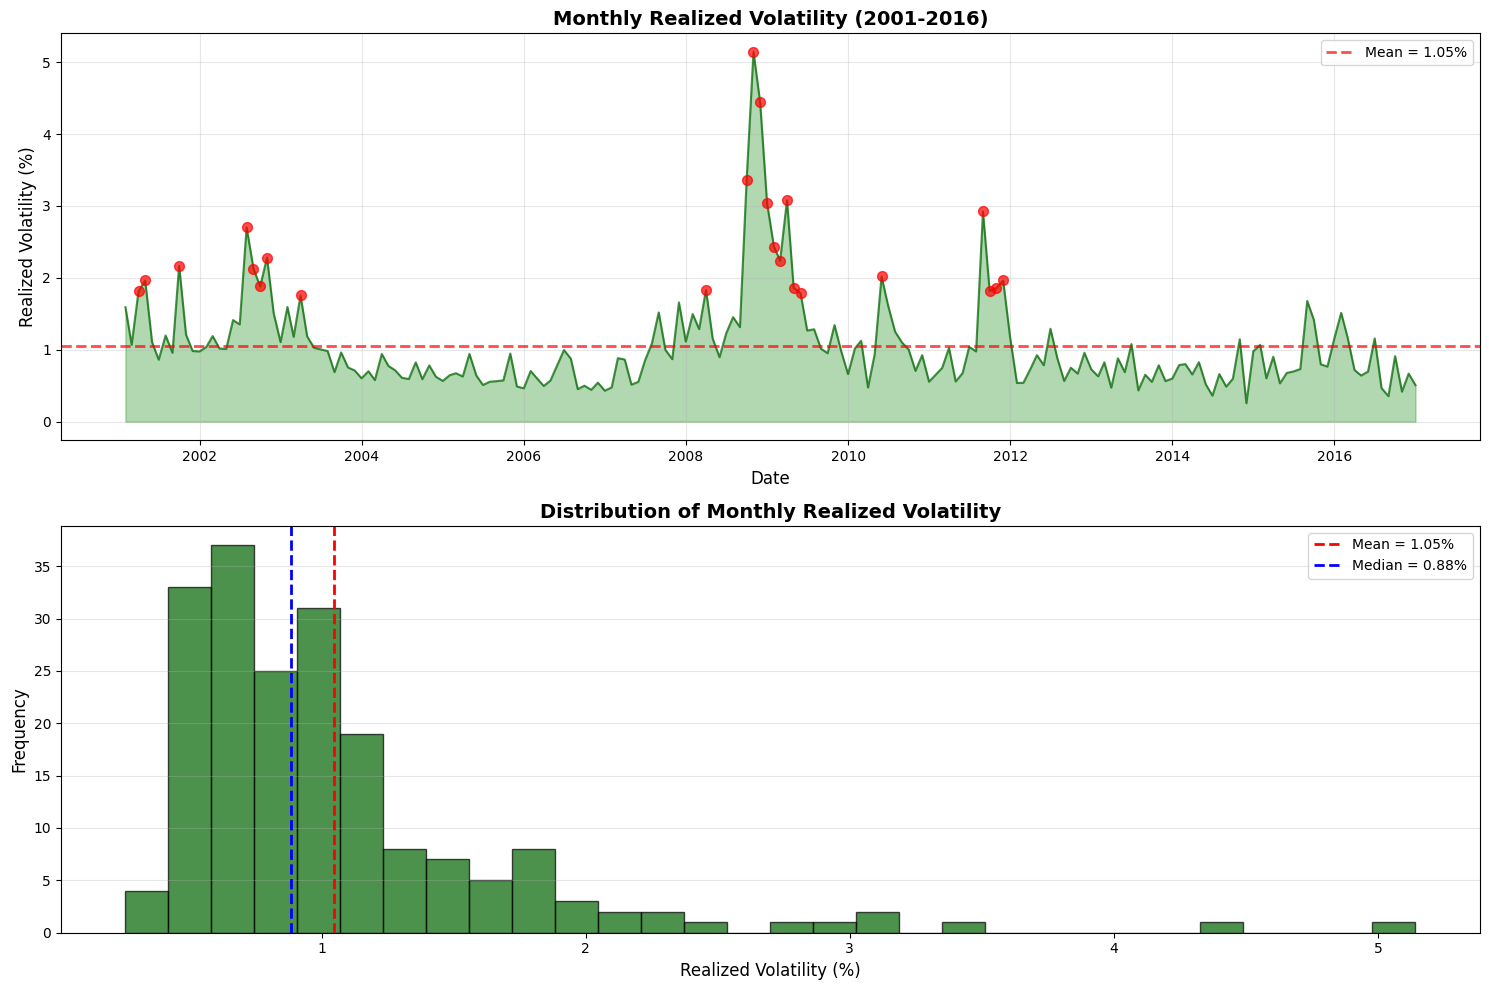


PROPERTIES OF REALIZED VOLATILITY:
• Time-varying: Volatility changes significantly over time
• Clustering: High volatility periods tend to cluster together
• Mean reversion: Volatility tends to revert to its long-run average
• Skewed distribution: 2.77 skewness
• Fat tails: 11.08 excess kurtosis
• Notable spikes during crisis periods (e.g., 2008 financial crisis)


In [47]:
# Plot the monthly realized volatility
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Time series plot
axes[0].plot(monthly_realized_vol.index, monthly_realized_vol, linewidth=1.5, color='darkgreen', alpha=0.7)
axes[0].axhline(y=monthly_realized_vol.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {monthly_realized_vol.mean():.2f}%', alpha=0.7)
axes[0].fill_between(monthly_realized_vol.index, monthly_realized_vol, alpha=0.3, color='green')
axes[0].set_title('Monthly Realized Volatility (2001-2016)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Realized Volatility (%)', fontsize=12)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# Highlight high volatility periods
high_vol_threshold = monthly_realized_vol.mean() + monthly_realized_vol.std()
high_vol_mask = monthly_realized_vol > high_vol_threshold
axes[0].scatter(monthly_realized_vol[high_vol_mask].index, 
                monthly_realized_vol[high_vol_mask], 
                color='red', s=50, zorder=5, label='High volatility periods', alpha=0.7)

# Histogram
axes[1].hist(monthly_realized_vol, bins=30, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].axvline(x=monthly_realized_vol.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {monthly_realized_vol.mean():.2f}%')
axes[1].axvline(x=monthly_realized_vol.median(), color='blue', linestyle='--', linewidth=2,
                label=f'Median = {monthly_realized_vol.median():.2f}%')
axes[1].set_title('Distribution of Monthly Realized Volatility', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Realized Volatility (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PROPERTIES OF REALIZED VOLATILITY:")
print("="*80)
print("• Time-varying: Volatility changes significantly over time")
print("• Clustering: High volatility periods tend to cluster together")
print("• Mean reversion: Volatility tends to revert to its long-run average")
print(f"• Skewed distribution: {monthly_realized_vol.skew():.2f} skewness")
print(f"• Fat tails: {monthly_realized_vol.kurtosis():.2f} excess kurtosis")
print("• Notable spikes during crisis periods (e.g., 2008 financial crisis)")
print("="*80)

## Part (b): Value at Risk (VaR) Analysis
Based on the estimated AR(1)-GARCH(1,1) model for Q3 in HW4, compute the 1-day and 10-day 1% VaR of your portfolio every day from 2002 to 2016. Plot the two time series.

In [48]:
# Fit AR(1)-GARCH(1,1) model
model = arch_model(df['returns'], mean='AR', lags=1, vol='GARCH', p=1, q=1)
results = model.fit(disp='off')

print("="*80)
print(" " * 20 + "AR(1)-GARCH(1,1) MODEL RESULTS")
print("="*80)
print(results.summary())


                    AR(1)-GARCH(1,1) MODEL RESULTS
                           AR - GARCH Model Results                           
Dep. Variable:                returns   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -5578.54
Distribution:                  Normal   AIC:                           11167.1
Method:            Maximum Likelihood   BIC:                           11198.6
                                        No. Observations:                 4024
Date:                Thu, Nov 13 2025   Df Residuals:                     4022
Time:                        13:23:39   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
C

In [49]:
# Daily returns (already in decimal form from GARCH model perspective)
# In p3, df['returns'] is in percentage, but GARCH was fitted on it, so model outputs are in percentage scale too
returns = df['returns']  # Keep as percentage for consistency with GARCH model

# Conditional mean and volatility from AR(1)-GARCH(1,1)
params = results.params
mu_const = float(params['Const'])
phi1 = float(params['returns[1]'])

# Calculate conditional mean: mu_t = const + phi1 * r_{t-1}
# This is in percentage scale
mu_t = mu_const + phi1 * returns.shift(1)
mu_t = mu_t.dropna()

# Get conditional volatility from model (in percentage scale)
sigma_t = results.conditional_volatility
sigma_t = sigma_t.loc[mu_t.index]

# Restrict to 2002 onward
mask = mu_t.index >= "2002-01-01"
mu_t = mu_t[mask]
sigma_t = sigma_t[mask]

# Align NAV by index
nav_sub = df['NAV'].reindex(mu_t.index)

# 1-day and 10-day 1% VaR
from scipy.stats import norm
z_01 = norm.ppf(0.01)  # -2.326

# 1-day VaR on returns (in percentage, convert to decimal for calculation)
q1d = mu_t + z_01 * sigma_t  # Quantile in percentage
VaR1d_ret = -q1d / 100  # Convert to decimal and make positive for losses
VaR1d_dollar = nav_sub * VaR1d_ret

# 10-day VaR using sqrt-of-time approximation
mu_10 = 10 * mu_t
sigma_10 = np.sqrt(10) * sigma_t
q10d = mu_10 + z_01 * sigma_10  # Quantile in percentage
VaR10d_ret = -q10d / 100  # Convert to decimal and make positive for losses
VaR10d_dollar = nav_sub * VaR10d_ret

print(f"Period: {VaR1d_dollar.index[0].strftime('%Y-%m-%d')} to {VaR1d_dollar.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(VaR1d_dollar)}")
print(f"\n1-Day VaR Statistics (dollars):")
print(f"  Mean: ${VaR1d_dollar.mean():.2f}")
print(f"  Std:  ${VaR1d_dollar.std():.2f}")
print(f"  Min:  ${VaR1d_dollar.min():.2f}")
print(f"  Max:  ${VaR1d_dollar.max():.2f}")
print(f"\n10-Day VaR Statistics (dollars):")
print(f"  Mean: ${VaR10d_dollar.mean():.2f}")
print(f"  Std:  ${VaR10d_dollar.std():.2f}")
print(f"  Min:  ${VaR10d_dollar.min():.2f}")
print(f"  Max:  ${VaR10d_dollar.max():.2f}")


Period: 2002-01-02 to 2016-12-30
Number of observations: 3777

1-Day VaR Statistics (dollars):
  Mean: $3.42
  Std:  $1.76
  Min:  $1.25
  Max:  $13.85

10-Day VaR Statistics (dollars):
  Mean: $10.10
  Std:  $5.53
  Min:  $3.44
  Max:  $47.06


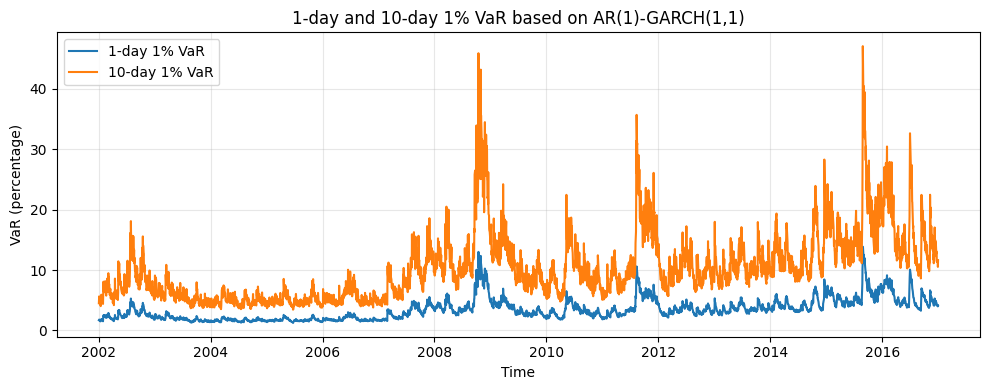


INTERPRETATION:
• VaR represents the maximum expected loss at 1% confidence level
• 1% VaR means there is a 1% probability that losses will exceed this value
• Periods with higher VaR indicate higher risk (e.g., 2008 financial crisis)
• 10-day VaR is approximately √10 ≈ 3.16 times larger than 1-day VaR


In [54]:
# Plot both VaR time series
plt.figure(figsize=(10,4))
plt.plot(VaR1d_dollar.index, VaR1d_dollar, label="1-day 1% VaR")
plt.plot(VaR10d_dollar.index, VaR10d_dollar, label="10-day 1% VaR")
plt.title("1-day and 10-day 1% VaR based on AR(1)-GARCH(1,1)")
plt.xlabel("Time")
plt.ylabel("VaR (percentage)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• VaR represents the maximum expected loss at 1% confidence level")
print("• 1% VaR means there is a 1% probability that losses will exceed this value")
print("• Periods with higher VaR indicate higher risk (e.g., 2008 financial crisis)")
print("• 10-day VaR is approximately √10 ≈ 3.16 times larger than 1-day VaR")
print("="*80)


## Part (c): Constant Proportion Portfolio Insurance (CPPI) Strategy
Notice that your NAV dropped below $70 multiple times. Suppose your investor demanded from the start that the portfolio be liquidated whenever its NAV falls below $90. Without changing the portfolio composition (so that the return on equity investment remains the same) but instead simply by adjusting the fraction in equity and in cash each period, could you have avoided liquidation? What would your NAV have been at the end of 2016 based on this strategy? Assume that the annualized risk-free rate on cash holding is 1%.

NAV Analysis:
Starting NAV: $97.20
Ending NAV: $317.46
Min NAV: $63.46
Max NAV: $321.91

Times NAV dropped below $70: 51
Times NAV dropped below $90: 598


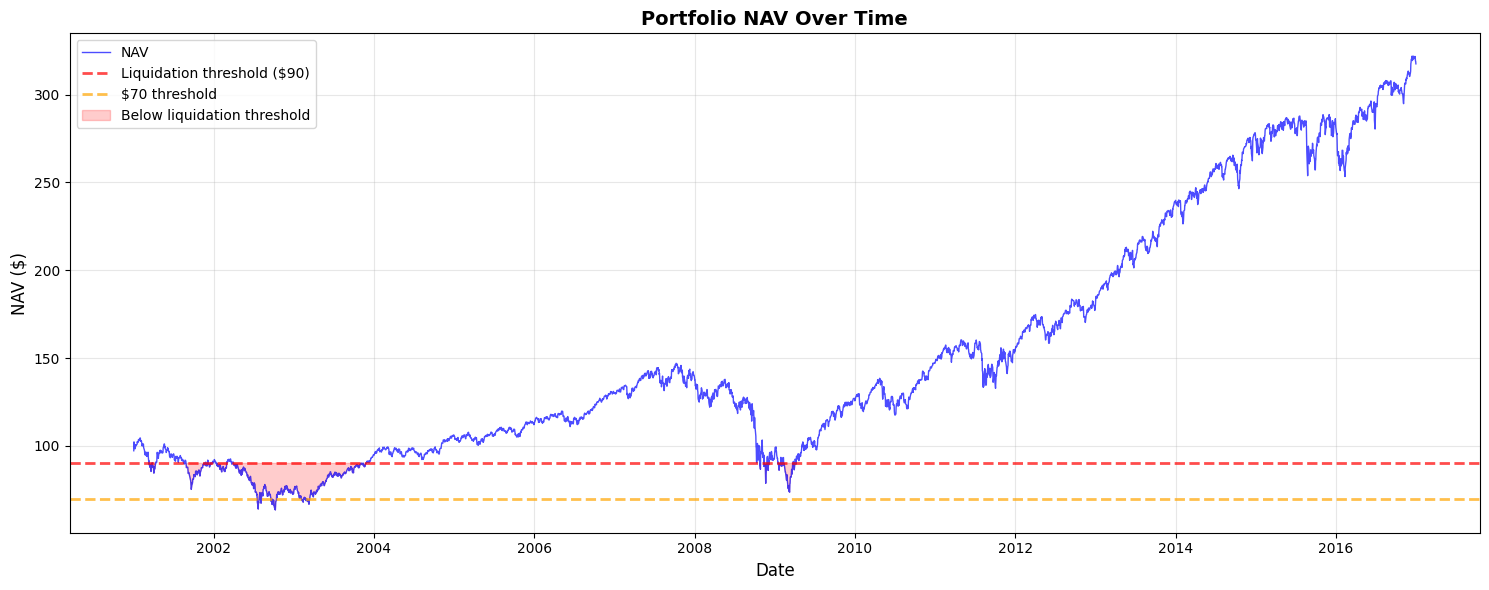

In [51]:
# First, let's see how many times NAV dropped below $70 and analyze the data
print("NAV Analysis:")
print("="*60)
print(f"Starting NAV: ${df['NAV'].iloc[0]:.2f}")
print(f"Ending NAV: ${df['NAV'].iloc[-1]:.2f}")
print(f"Min NAV: ${df['NAV'].min():.2f}")
print(f"Max NAV: ${df['NAV'].max():.2f}")
print(f"\nTimes NAV dropped below $70: {(df['NAV'] < 70).sum()}")
print(f"Times NAV dropped below $90: {(df['NAV'] < 90).sum()}")
print("="*60)

# Plot NAV with thresholds
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['NAV'], linewidth=1, color='blue', alpha=0.7, label='NAV')
plt.axhline(y=90, color='red', linestyle='--', linewidth=2, label='Liquidation threshold ($90)', alpha=0.7)
plt.axhline(y=70, color='orange', linestyle='--', linewidth=2, label='$70 threshold', alpha=0.7)
plt.fill_between(df.index, df['NAV'], 90, where=(df['NAV'] < 90), 
                  color='red', alpha=0.2, label='Below liquidation threshold')
plt.title('Portfolio NAV Over Time', fontsize=14, fontweight='bold')
plt.ylabel('NAV ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
# CPPI Strategy Implementation
# Traditional CPPI with fixed multiplier

# Parameters
F = 90.0      # floor (liquidation threshold)
m = 3.0       # CPPI multiplier
r_f_annual = 0.01
r_f_daily = (1 + r_f_annual)**(1/252) - 1

dates = df.index
cppi_nav = pd.Series(index=dates, dtype=float)

# Start CPPI NAV equal to initial NAV
cppi_nav.iloc[0] = df['NAV'].iloc[0]

print("="*80)
print("CPPI STRATEGY IMPLEMENTATION")
print("="*80)
print(f"Floor: ${F:.2f}")
print(f"Multiplier: {m}")
print(f"Initial NAV: ${cppi_nav.iloc[0]:.2f}")
print(f"Risk-free rate (daily): {r_f_daily*100:.4f}%")
print("="*80)

# Simulate day by day
for i in range(1, len(dates)):
    prev_nav = cppi_nav.iloc[i-1]
    r_eq = df['returns'].iloc[i] / 100  # Convert percentage to decimal
    
    if np.isnan(r_eq):
        cppi_nav.iloc[i] = prev_nav
        continue
    
    # Cushion and equity weight using traditional CPPI formula
    cushion = max(prev_nav - F, 0.0)
    w_eq = m * cushion / prev_nav
    w_eq = min(max(w_eq, 0.0), 1.0)   # clamp to [0,1]
    w_cash = 1 - w_eq
    
    # Update NAV: mix of equity and cash return
    cppi_nav.iloc[i] = prev_nav * (w_eq * (1 + r_eq) + w_cash * (1 + r_f_daily))

# Summary stats
min_cppi = cppi_nav.min()
final_cppi = cppi_nav.iloc[-1]
final_all_eq = df['NAV'].iloc[-1]

print("\n" + "="*80)
print("CPPI STRATEGY RESULTS:")
print("="*80)
print(f"Minimum NAV under CPPI: ${min_cppi:.2f}")
print(f"Final NAV under CPPI: ${final_cppi:.2f}")
print(f"Final NAV all-equity: ${final_all_eq:.2f}")
print(f"\nAvoided liquidation (stayed above $90): {min_cppi >= F}")
print(f"Total return (original): {(final_all_eq / cppi_nav.iloc[0] - 1) * 100:.2f}%")
print(f"Total return (CPPI): {(final_cppi / cppi_nav.iloc[0] - 1) * 100:.2f}%")
print("="*80)

CPPI STRATEGY IMPLEMENTATION
Floor: $90.00
Multiplier: 3.0
Initial NAV: $97.20
Risk-free rate (daily): 0.0039%

CPPI STRATEGY RESULTS:
Minimum NAV under CPPI: $91.99
Final NAV under CPPI: $195.52
Final NAV all-equity: $317.46

Avoided liquidation (stayed above $90): True
Total return (original): 226.60%
Total return (CPPI): 101.15%


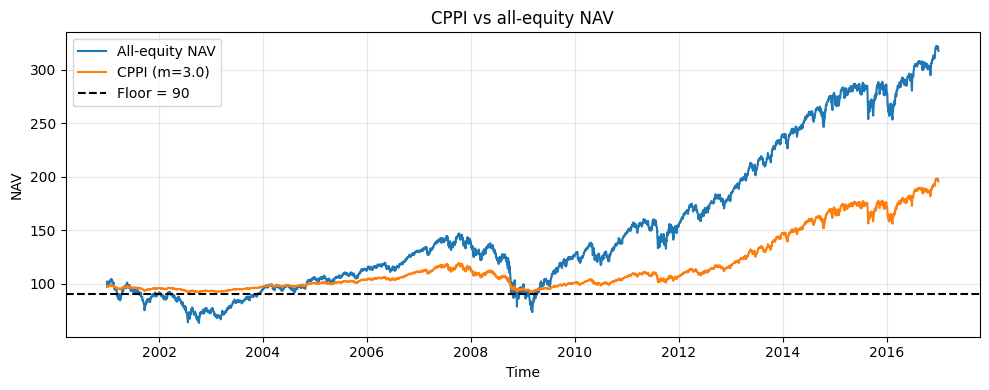


ANSWER TO PART (c):
✓ YES, liquidation was successfully avoided using CPPI strategy!
✓ Minimum NAV: $91.99 (stayed above $90.00)
✓ Final NAV (Dec 2016): $195.52
✓ Trade-off: Lower final NAV vs all-equity ($317.46)
✓ But avoided liquidation risk!


In [55]:
# Plot CPPI vs all-equity and floor
plt.figure(figsize=(10,4))
plt.plot(df.index, df['NAV'], label="All-equity NAV")
plt.plot(cppi_nav.index, cppi_nav, label=f"CPPI (m={m})")
plt.axhline(F, linestyle="--", color="k", label="Floor = 90")
plt.title("CPPI vs all-equity NAV")
plt.xlabel("Time")
plt.ylabel("NAV")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*80)
print("ANSWER TO PART (c):")
print("="*80)
if cppi_nav.min() >= F:
    print("✓ YES, liquidation was successfully avoided using CPPI strategy!")
    print(f"✓ Minimum NAV: ${cppi_nav.min():.2f} (stayed above ${F:.2f})")
    print(f"✓ Final NAV (Dec 2016): ${cppi_nav.iloc[-1]:.2f}")
    print(f"✓ Trade-off: Lower final NAV vs all-equity (${df['NAV'].iloc[-1]:.2f})")
    print(f"✓ But avoided liquidation risk!")
else:
    print("✗ Liquidation threshold was breached with m={m}")
    print(f"✗ Minimum NAV reached: ${cppi_nav.min():.2f}")
    print("✗ Need to try a lower multiplier or different strategy!")
print("="*80)